In [212]:
# Imports
from PIL import Image, ImageFilter, ImageChops, ImageOps,ImageDraw
import matplotlib.pyplot as plt
import numpy as np
import time


In [213]:
# Load an image 
image = Image.open('music3.png')

In [214]:
# Convert the image to grayscale
gray = ImageOps.grayscale(image)

# Apply Gaussian smoothing
smoothed = gray.filter(ImageFilter.GaussianBlur(radius=1))

# Invert the image
inverted = ImageOps.invert(smoothed)

edge_image = inverted

edge_image = edge_image.filter(ImageFilter.MinFilter(3))

#convert image to array
edge_array = np.array(edge_image)

In [215]:
#range of theta, rho and parallel distance
thetas = np.deg2rad(np.arange(90, 91, 2))#np.deg2rad(np.arange(0, 180, 2))
height,width = edge_array.shape
diag_len = height
rhos = np.arange(0, diag_len, 2)
spacing = np.arange(0,int(height/10),2)

accumulator = np.zeros((len(rhos),len(thetas),len(spacing)))

In [216]:
mod_edge = np.where(edge_array>10,edge_array,0)
x_idxs = np.nonzero(mod_edge)[1]
y_idxs = np.nonzero(mod_edge)[0]

In [217]:
cos_theta = np.cos(thetas)
sin_theta = np.sin(thetas)

xcosthetas = np.dot(x_idxs.reshape((-1,1)), cos_theta.reshape((1,-1)))
ysinthetas = np.dot(y_idxs.reshape((-1,1)), sin_theta.reshape((1,-1)))

In [218]:
rhosmat = xcosthetas + ysinthetas
rhosmat = np.ceil(rhosmat/2)*2

In [219]:
%%time
#iterate through range of thetas
for t_idx in range(len(thetas)):
    #iterate through rhos
    for r_idx in range(len(rhos)):
        #iterate through parallel distance
        for s_idx in range(1,len(spacing)):
            #get calculated rho values from rho matrix for the given theta
            rho_dash = rhosmat[:,t_idx]
            #calculate difference between calculated rho and the r_idx
            difference = rho_dash- rhos[r_idx]
            #check if the difference is equal to 1,2,3,4 times spacing and count number of pixels
            # zero_spacing = np.sum(difference==0)
            # one_spacing = np.sum(difference==spacing[s_idx])#[0].shape[0]

            # two_spacing = np.sum(difference==2*spacing[s_idx])#[0].shape[0]
            # three_spacing = np.sum(difference==3*spacing[s_idx])#[0].shape[0]
            # four_spacing = np.sum(difference==4*spacing[s_idx])#[0].shape[0]
            
            # total_votes =  one_spacing+two_spacing+three_spacing+four_spacing +zero_spacing
            temp_spac = [0,spacing[s_idx],2*spacing[s_idx],3*spacing[s_idx],4*spacing[s_idx]]

            total_votes = np.sum(np.isin(difference,temp_spac))#one_spacing+two_spacing+three_spacing+four_spacing+zero_spacing
            
            
            accumulator[r_idx,t_idx,s_idx]+=total_votes

CPU times: user 7.6 s, sys: 44.5 ms, total: 7.65 s
Wall time: 7.86 s


In [220]:
#get index which contains maximum votes
max_rho_idx, max_theta_idx, max_spac_idx = np.unravel_index(accumulator.argmax(), accumulator.shape)

In [221]:
# row,col =
mr_idx,mt_idx,ms_idx = np.unravel_index(np.argsort(accumulator.ravel()),accumulator.shape)

In [222]:
# mr_idx[-17:
# check = np.where(accumulator[:,max_theta_idx,max_spac_idx]>=0.7*np.max(accumulator))
# np.unravel_index(np.argsort(check.ravel()),check.shape)[0]

In [223]:
accumulator_sub = accumulator[:,max_theta_idx,max_spac_idx]
mask = accumulator_sub >= 0.7*np.max(accumulator_sub)
sort_idx = accumulator_sub.argsort()
final_rhos_idx = sort_idx[mask[sort_idx]]

In [224]:
#non maximal suppression for hough lines
final_rhos_idx_nms= []
for idx in range(len(final_rhos_idx)-1,-1,-1):
  curr_val = final_rhos_idx[idx]
  min_val = final_rhos_idx[idx] - (max_spac_idx*5)
  max_val = final_rhos_idx[idx] + (max_spac_idx*5)
  temp_list = [x for x in range(min_val,max_val+1)]
  is_absent = True
  for ele in temp_list:
    if ele in final_rhos_idx_nms:
      is_absent = False
      break

  if is_absent:
    final_rhos_idx_nms.append(final_rhos_idx[idx])

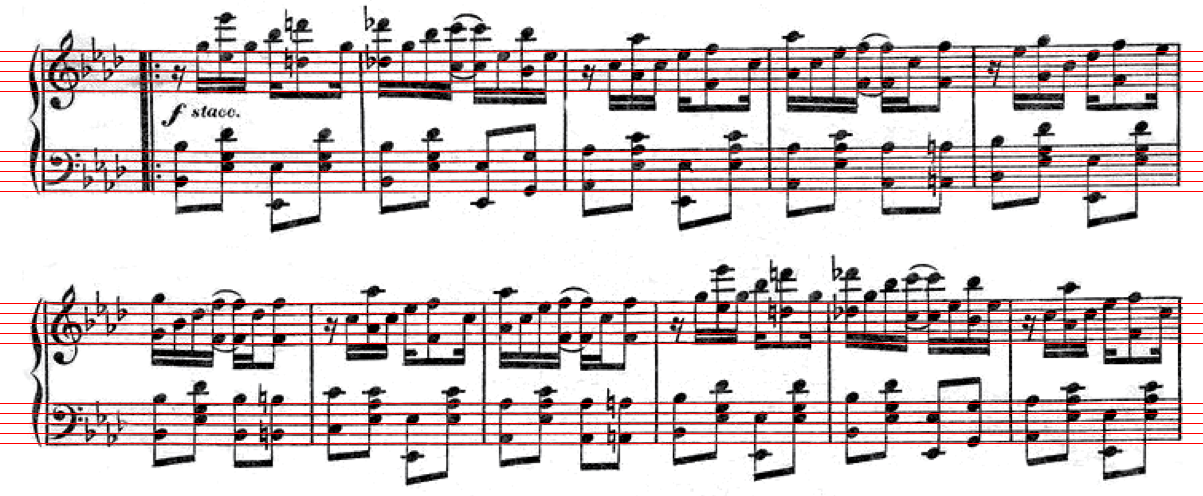

In [225]:
img_rgb = image.convert("RGB")
draw = ImageDraw.Draw(img_rgb)
max_line_length = 10000

#theta of first line
first_line_theta = thetas[max_theta_idx]

#distance between parallel lines
dist_prll = spacing[max_spac_idx]

# for line in range(5):
#     cos_th = np.cos(first_line_theta)
#     sin_th = np.sin(first_line_theta)
    
#     x0 = cos_th * (first_line_rho + (line*dist_prll) )
#     y0 = sin_th * (first_line_rho + (line*dist_prll) )
#     #first point
#     x1 = int(x0 + max_line_length * (-sin_th))
#     y1 = int(y0 + max_line_length * cos_th)
#     #second point
#     x2 = int(x0 - max_line_length * (-sin_th))
#     y2 = int(y0 - max_line_length * cos_th)
#     # print((x1, y1, x2, y2))
#     draw.line((x1, y1, x2, y2), fill=(255,0,0), width=1)

for fin_rho in final_rhos_idx_nms:
  first_line_rho = rhos[fin_rho]
  for line in range(5):
      cos_th = np.cos(first_line_theta)
      sin_th = np.sin(first_line_theta)
      
      x0 = cos_th * (first_line_rho + (line*dist_prll) )
      y0 = sin_th * (first_line_rho + (line*dist_prll) )
      #first point
      x1 = int(x0 + max_line_length * (-sin_th))
      y1 = int(y0 + max_line_length * cos_th)
      #second point
      x2 = int(x0 - max_line_length * (-sin_th))
      y2 = int(y0 - max_line_length * cos_th)
      # print((x1, y1, x2, y2))
      draw.line((x1, y1, x2, y2), fill=(255,0,0), width=1)


# for line in range(5):
#     cos_th = np.cos(first_line_theta)
#     sin_th = np.sin(first_line_theta)
    
#     x0 = cos_th * (second_rho + (line*second_space) )
#     y0 = sin_th * (second_rho + (line*second_space) )
#     #first point
#     x1 = int(x0 + max_line_length * (-sin_th))
#     y1 = int(y0 + max_line_length * cos_th)
#     #second point
#     x2 = int(x0 - max_line_length * (-sin_th))
#     y2 = int(y0 - max_line_length * cos_th)
#     # print((x1, y1, x2, y2))
#     draw.line((x1, y1, x2, y2), fill=(255,0,0), width=1)

img_rgb

In [226]:
def cross_correlation(img, template, threshold=0.7):
    m, n = template.shape[:2]
    img_h, img_w = img.shape[:2]
    result = np.zeros((img_h - m + 1, img_w - n + 1))

    # normalize template
    template = (template - np.mean(template)) / np.std(template)

    for i in range(result.shape[0]):
        for j in range(result.shape[1]):
            roi = img[i:i+m, j:j+n]

            # normalize roi
            roi = (roi - np.mean(roi)) / np.std(roi)

            # compute dot product
            dot_product = (roi * template).sum()

            # compute similarity measure
            similarity = dot_product

            result[i, j] = similarity
            
    # find locations with similarity above threshold
    locs = np.where(result >= threshold*np.nanmax(result))
    # filter the array to only include values greater than certain threshold
    filtered_arr = result[result > threshold*np.nanmax(result)]

    # get the indices of the filtered values in the original array
    filtered_indices = np.where(result > threshold*np.nanmax(result))

    # get the sorted indices of the filtered values based on their values
    sorted_filtered_indices = np.argsort(filtered_arr)

    # sort the row and column indices in the tuple based on the sorted indices of the filtered values
    sorted_filtered_indices_tuple = (filtered_indices[0][sorted_filtered_indices], filtered_indices[1][sorted_filtered_indices])


    locs = list(zip(sorted_filtered_indices_tuple[1], sorted_filtered_indices_tuple[0]))

    return result,locs


In [227]:

# load image and template
img = image.convert('L').filter(ImageFilter.MaxFilter(5))
template = Image.open('template1.png').convert('L')

img_arr = np.array(img)
templ_arr = np.array(template.resize((template.width,dist_prll)))

# compute cross-correlation
result,locs = cross_correlation(img_arr, templ_arr,threshold = 0.7)


<ipython-input-226-362f86998786>:14: RuntimeWarning: invalid value encountered in true_divide
  roi = (roi - np.mean(roi)) / np.std(roi)


In [228]:
template2 = Image.open('template2.png').convert('L')
templ2_arr = np.array(template2) #.resize((template2.width,2*dist_prll)))
result2,locs2 = cross_correlation(np.array(image.convert('L')), templ2_arr)

template3 = Image.open('template3.png').convert('L')
templ3_arr = np.array(template3) #.resize((template2.width,2*dist_prll)))
result3,locs3 = cross_correlation(np.array(image.convert('L')), templ3_arr)

<ipython-input-226-362f86998786>:14: RuntimeWarning: invalid value encountered in true_divide
  roi = (roi - np.mean(roi)) / np.std(roi)


In [229]:
bass_temp = Image.open('bass_template.png').convert('L')
bass_result,bass_locs = cross_correlation(np.array(image.convert('L')), np.array(bass_temp)[10:-10],threshold=0.9)

treble_temp = Image.open('treble_template.png').convert('L')
treble_result,treble_locs = cross_correlation(np.array(image.convert('L')), np.array(treble_temp),threshold=0.9)

<ipython-input-226-362f86998786>:14: RuntimeWarning: invalid value encountered in true_divide
  roi = (roi - np.mean(roi)) / np.std(roi)


In [258]:
Image.fromarray(np.array(bass_temp)[10:-10]).save('bass_temp.png')

In [230]:
nms_list = []
locs = locs[::-1]
img_rgb = image.convert("RGB")
draw = ImageDraw.Draw(img_rgb)
for loc in locs:
    top_left = loc
    #generate +4 to left, right, top and bottom
#     is_absent = True
    is_absent = True
    x = loc
    # temp_list = [(x[0]+i,x[1]) for i in range(-dist_prll,dist_prll+1)] + [(x[0],x[1]+i) for i in range(-12,13)] + [(x[0]+i,x[1]+i) for i in range(-12,13)]\
    # +[(x[0]+i,x[1]-i) for i in range(-12,13)] + [(x[0]-i,x[1]+i) for i in range(-12,13)]
    temp_list = []
    for i in range(-dist_prll,dist_prll+1):
        temp_list.append((x[0]+i,x[1]))
        temp_list.append((x[0],x[1]+i))
        temp_list.append((x[0]+i,x[1]+i))
        temp_list.append((x[0]+i,x[1]-i))
        temp_list.append((x[0]-i,x[1]+i))

        for j in range(-dist_prll,dist_prll+1):
            temp_list.append((x[0]+i,x[1]+j))
            temp_list.append((x[0]-i,x[1]-j))
    for ele in temp_list:
        if ele in nms_list:
            is_absent=False
            break
    if is_absent:
        bottom_right = (top_left[0] + templ_arr.shape[1], top_left[1] + templ_arr.shape[0])
        draw.rectangle((top_left, bottom_right), outline='red')
        nms_list.append(loc)


In [231]:
# # img_rgb = image.convert("RGB")
# # draw = ImageDraw.Draw(img_rgb)
# max_line_length = 10000
# nms_list2 = []

# locs2 = locs2[::-1]
# for loc in locs2:
#     top_left = loc
#     #generate +4 to left, right, top and bottom
#     is_absent = True
#     x = loc
#     # temp_list = [(x[0]+i,x[1]) for i in range(-dist_prll,dist_prll+1)] + [(x[0],x[1]+i) for i in range(-12,13)] + [(x[0]+i,x[1]+i) for i in range(-12,13)]\
#     # +[(x[0]+i,x[1]-i) for i in range(-12,13)] + [(x[0]-i,x[1]+i) for i in range(-12,13)]
#     temp_list = []
#     for i in range(-2*dist_prll,2*dist_prll+1):
#         temp_list.append((x[0]+i,x[1]))
#         temp_list.append((x[0],x[1]+i))
#         temp_list.append((x[0]+i,x[1]+i))
#         temp_list.append((x[0]+i,x[1]-i))
#         temp_list.append((x[0]-i,x[1]+i))

#         for j in range(-2*dist_prll,2*dist_prll+1):
#             temp_list.append((x[0]+i,x[1]+j))
#             temp_list.append((x[0]-i,x[1]-j))
#     for ele in temp_list:
#         if ele in nms_list2:
#             is_absent=False
#             break
#     if is_absent:
#         bottom_right = (top_left[0] + templ_arr.shape[1], top_left[1] + templ2_arr.shape[0])
#         draw.rectangle((top_left[0],top_left[1], bottom_right[0],bottom_right[1]), outline='red')
#         nms_list2.append(loc)


In [232]:
def non_max_suppression(locs,dist_prll,templ_arr):
  nms_list = []
  # locs = locs[::-1]
  for loc_idx in range(len(locs)-1,-1,-1):
      top_left = locs[loc_idx]
      #generate +4 to left, right, top and bottom
      is_absent = True
      x = top_left
      temp_list = []
      for i in range(-2*dist_prll,2*dist_prll+1):
          temp_list.append((x[0]+i,x[1]))
          temp_list.append((x[0],x[1]+i))
          temp_list.append((x[0]+i,x[1]+i))
          temp_list.append((x[0]+i,x[1]-i))
          temp_list.append((x[0]-i,x[1]+i))

          for j in range(-2*dist_prll,2*dist_prll+1):
              temp_list.append((x[0]+i,x[1]+j))
              temp_list.append((x[0]-i,x[1]-j))
      for ele in temp_list:
          if ele in nms_list:
              is_absent=False
              break
      if is_absent:
          # bottom_right = (top_left[0] + templ_arr.shape[1], top_left[1] + templ2_arr.shape[0])
          # draw.rectangle((top_left[0],top_left[1], bottom_right[0],bottom_right[1]), outline='red')
          nms_list.append(top_left)
  return nms_list


In [233]:
quarter_rest = non_max_suppression(locs2,template2.height,templ2_arr)
eight_rest = non_max_suppression(locs3,template2.height,templ3_arr)

NameError: ignored

In [249]:
bass_nms_locs = non_max_suppression(bass_locs,bass_temp.height,np.array(bass_temp))
bass_pos = [x[1] for x in bass_nms_locs]

treble_nms_locs = non_max_suppression(treble_locs,treble_temp.height,np.array(treble_temp))
treble_pos = [x[1] for x in treble_nms_locs]

bass_range = []
treble_range = []
for pos in bass_pos:
  bass_range = bass_range + [x for x in range(pos-dist_prll,pos+bass_temp.height +1)]

for pos in treble_pos:
  treble_range = treble_range + [x for x in range(pos-dist_prll,pos+treble_temp.height+1)]


In [250]:
final_pos_sorted = rhos[final_rhos_idx_nms]
final_pos_sorted.sort()

In [251]:
from PIL import ImageFont
fnt = ImageFont.truetype("pillowfont.ttf",size=20)

In [252]:
detected = open("detected.txt","w")

middle = (dist_prll//2)
img_rgb = image.convert("RGB")
draw = ImageDraw.Draw(img_rgb)
for lo in nms_list:
  top_left = lo
  bottom_right = (top_left[0] + templ_arr.shape[1], top_left[1] + templ_arr.shape[0])
  draw.rectangle((top_left[0],top_left[1], bottom_right[0],bottom_right[1]), outline='red')
        
for first_pos in final_pos_sorted:
  if first_pos in treble_range:
    notes_locs = []
    for loc in nms_list:
      if first_pos - (3*dist_prll) <=loc[1]<= first_pos + (7*dist_prll):
        notes_locs.append(loc)
    for note_loc in notes_locs:
      #A
      if (first_pos+(2*dist_prll)-2 <= note_loc[1] <= first_pos+(2*dist_prll)+2) or (first_pos-dist_prll-2 <= note_loc[1]+middle <=first_pos-dist_prll+2):
        # define the position and text of the letter
        x, y = note_loc[0]+20, note_loc[1]
        # draw the letter
        detected.write(f"{y} {x} {dist_prll} {template.width} filled_note A high \n")
        draw.text((x, y), 'A', font = fnt,fill='red')

      #B
      elif (first_pos+(2*dist_prll)-2 <= note_loc[1]+middle <= first_pos+(2*dist_prll)+2) or (first_pos+(5*dist_prll)-2 <= note_loc[1] <=first_pos+(5*dist_prll)+2):
        # define the position and text of the letter
        x, y = note_loc[0]+20, note_loc[1]
        # draw the letter
        detected.write(f"{y} {x} {dist_prll} {template.width} filled_note B high \n")
        draw.text((x, y), 'B',font = fnt, fill='red')

      #C
      elif (first_pos+(1*dist_prll)-2 <= note_loc[1] <= first_pos+(1*dist_prll)+2) or (first_pos+(5*dist_prll)-2 <= note_loc[1]+middle <=first_pos+(5*dist_prll)+2):
        # define the position and text of the letter
        x, y = note_loc[0]+20, note_loc[1]
        # draw the letter
        detected.write(f"{y} {x} {dist_prll} {template.width} filled_note C high \n")
        draw.text((x, y), 'C',font = fnt, fill='red')
      
      #D
      elif (first_pos+(1*dist_prll)-2 <= note_loc[1]+middle <= first_pos+(1*dist_prll)+2) or (first_pos+(4*dist_prll)-2 <= note_loc[1] <=first_pos+(4*dist_prll)+2):
        # define the position and text of the letter
        x, y = note_loc[0]+20, note_loc[1]
        # draw the letter
        detected.write(f"{y} {x} {dist_prll} {template.width} filled_note D high \n")
        draw.text((x, y), 'D',font = fnt, fill='red')

      #E
      elif (first_pos+(0*dist_prll)-2 <= note_loc[1] <= first_pos+(0*dist_prll)+2) or (first_pos+(4*dist_prll)-2 <= note_loc[1]+middle <=first_pos+(4*dist_prll)+2):
        # define the position and text of the letter
        x, y = note_loc[0]+20, note_loc[1]
        # draw the letter
        detected.write(f"{y} {x} {dist_prll} {template.width} filled_note E high \n")
        draw.text((x, y), 'E',font = fnt, fill='red')
      
      #F
      elif (first_pos+(0*dist_prll)-2 <= note_loc[1]+middle <= first_pos+(0*dist_prll)+2) or (first_pos+(3*dist_prll)-2 <= note_loc[1] <=first_pos+(3*dist_prll)+2):
        # define the position and text of the letter
        x, y = note_loc[0]+20, note_loc[1]
        # draw the letter
        detected.write(f"{y} {x} {dist_prll} {template.width} filled_note F high \n")
        draw.text((x, y), 'F',font = fnt, fill='red')
      #G
      elif (first_pos+(0*dist_prll)-2 <= note_loc[1]+dist_prll <= first_pos+(0*dist_prll)+2) or (first_pos+(3*dist_prll)-2 <= note_loc[1]+middle <=first_pos+(3*dist_prll)+2):
        # define the position and text of the letter
        x, y = note_loc[0]+20, note_loc[1]
        # draw the letter
        detected.write(f"{y} {x} {dist_prll} {template.width} filled_note G high \n")
        draw.text((x, y), 'G',font = fnt, fill='red')
  else:
    notes_bass_locs = []
    for loc in nms_list:
      if first_pos - (3*dist_prll) <=loc[1]<= first_pos + (7*dist_prll):
        notes_bass_locs.append(loc)
    for note_loc in notes_bass_locs:
      #A
      if (first_pos+(3*dist_prll)-2 <= note_loc[1] <= first_pos+(3*dist_prll)+2) or (first_pos-2 <= note_loc[1]+middle <=first_pos+2):
        # define the position and text of the letter
        x, y = note_loc[0]+20, note_loc[1]
        # draw the letter
        detected.write(f"{y} {x} {dist_prll} {template.width} filled_note A high \n")
        draw.text((x, y), 'A',font = fnt, fill='red')

      #B
      elif (first_pos+(3*dist_prll)-2 <= note_loc[1]+middle <= first_pos+(3*dist_prll)+2) or (first_pos+(0*dist_prll)-2 <= note_loc[1]+dist_prll <=first_pos+(0*dist_prll)+2):
        # define the position and text of the letter
        x, y = note_loc[0]+20, note_loc[1]
        # draw the letter
        detected.write(f"{y} {x} {dist_prll} {template.width} filled_note B high \n")
        draw.text((x, y), 'B',font = fnt, fill='red')

      #C
      elif (first_pos+(2*dist_prll)-2 <= note_loc[1] <= first_pos+(2*dist_prll)+2) or (first_pos-(1*dist_prll)-2 <= note_loc[1]+middle <=first_pos-(1*dist_prll)+2) or (first_pos+(6*dist_prll)-2 <= note_loc[1]+middle <=first_pos+(6*dist_prll)+2):
        # define the position and text of the letter
        x, y = note_loc[0]+20, note_loc[1]
        # draw the letter
        detected.write(f"{y} {x} {dist_prll} {template.width} filled_note C high \n")
        draw.text((x, y), 'C', font = fnt,fill='red')
      
      #D
      elif (first_pos+(2*dist_prll)-2 <= note_loc[1]+middle <= first_pos+(2*dist_prll)+2)  or (first_pos+(5*dist_prll)-2 <= note_loc[1] <=first_pos+(5*dist_prll)+2):
        # define the position and text of the letter
        x, y = note_loc[0]+20, note_loc[1]
        # draw the letter
        detected.write(f"{y} {x} {dist_prll} {template.width} filled_note D high \n")
        draw.text((x, y), 'D',font = fnt, fill='red')

      #E
      elif (first_pos+(1*dist_prll)-2 <= note_loc[1] <= first_pos+(1*dist_prll)+2) or (first_pos+(5*dist_prll)-2 <= note_loc[1]+middle <=first_pos+(5*dist_prll)+2):
        # define the position and text of the letter
        x, y = note_loc[0]+20, note_loc[1]
        # draw the letter
        detected.write(f"{y} {x} {dist_prll} {template.width} filled_note E high \n")
        draw.text((x, y), 'E',font = fnt, fill='red')
      
      #F
      elif (first_pos+(4*dist_prll)-2 <= note_loc[1] <= first_pos+(4*dist_prll)+2) or (first_pos+(1*dist_prll)-2 <= note_loc[1]+middle <=first_pos+(1*dist_prll)+2):
        # define the position and text of the letter
        x, y = note_loc[0]+20, note_loc[1]
        # draw the letter
        detected.write(f"{y} {x} {dist_prll} {template.width} filled_note F high \n")
        draw.text((x, y), 'F',font = fnt, fill='red')
      
      #G
      elif (first_pos+(4*dist_prll)-2 <= note_loc[1]+middle <= first_pos+(4*dist_prll)+2) or (first_pos+(0*dist_prll)-2 <= note_loc[1] <=first_pos+(0*dist_prll)+2):
        # define the position and text of the letter
        x, y = note_loc[0]+20, note_loc[1]
        # draw the letter
        detected.write(f"{y} {x} {dist_prll} {template.width} filled_note G high \n")
        draw.text((x, y), 'G',font = fnt, fill='red')

In [253]:
for quart_loc in quarter_rest:
  top_left = quart_loc
  bottom_right = (top_left[0] + templ2_arr.shape[1], top_left[1] + templ2_arr.shape[0])
  detected.write(f"{top_left[1]} {top_left[0]} {int(2.4*dist_prll)} {template2.width} quarter_rest _ high \n")
  draw.rectangle((top_left[0],top_left[1], bottom_right[0],bottom_right[1]), outline='green')
  

for eight_loc in eight_rest:
  top_left = eight_loc
  bottom_right = (top_left[0] + templ3_arr.shape[1], top_left[1] + templ3_arr.shape[0])
  detected.write(f"{top_left[1]} {top_left[0]} {2*dist_prll} {template3.width} eighth_rest _ high \n")
  draw.rectangle((top_left[0],top_left[1], bottom_right[0],bottom_right[1]), outline='blue')
  

In [254]:
detected.close()

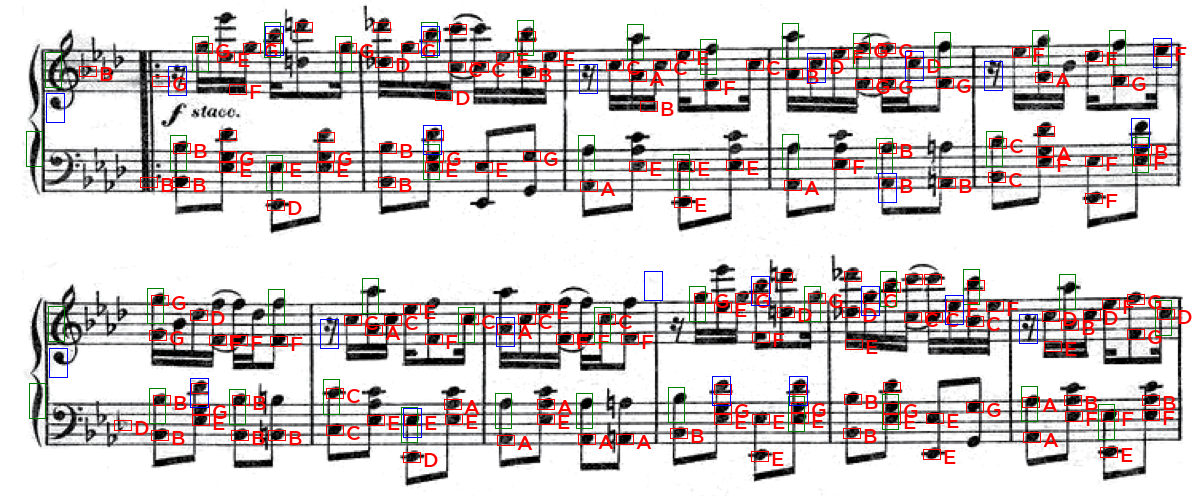

In [255]:
img_rgb

In [244]:
final_pos_sorted[2] in treble_range

False

In [246]:
treble_pos

[269, 14]

In [245]:
final_pos_sorted

array([ 52, 152, 304, 404])

In [209]:
treble_pos

[269, 14]

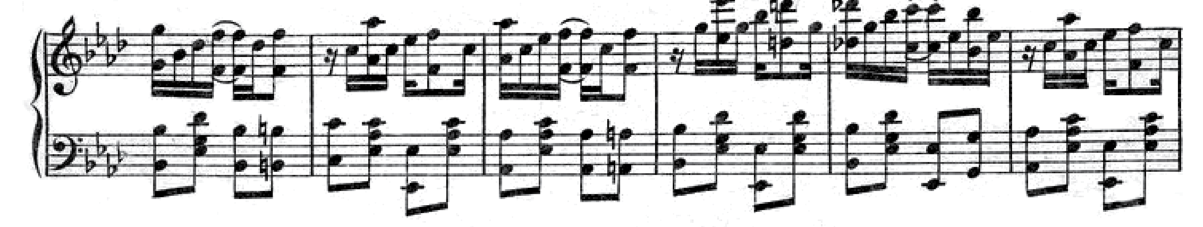

In [211]:
Image.fromarray(np.array(image)[269:])

In [147]:
middle = (dist_prll//2)
img_rgb = image.convert("RGB")
draw = ImageDraw.Draw(img_rgb)
for lo in nms_list:
  top_left = lo
  bottom_right = (top_left[0] + templ_arr.shape[1], top_left[1] + templ_arr.shape[0])
  draw.rectangle((top_left[0],top_left[1], bottom_right[0],bottom_right[1]), outline='red')
        

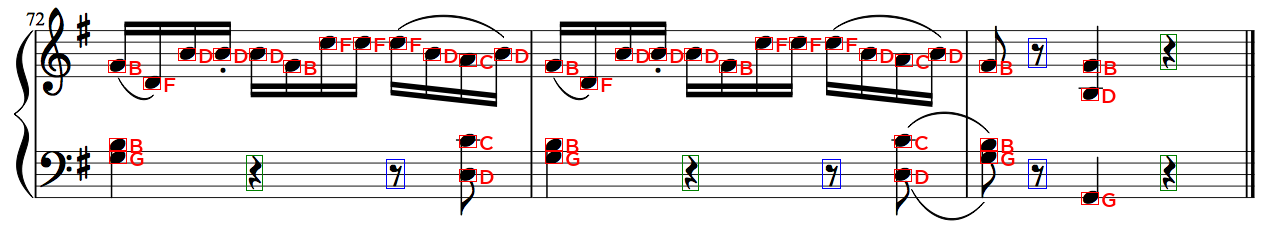

In [149]:
# nms_list

In [748]:
# bass
# font = ImageFont.truetype('arial.ttf', 24)
# img_rgb = image.convert("RGB")
# draw = ImageDraw.Draw(img_rgb)
first_pos = 152
middle = (dist_prll//2)

for note_loc in bass_pos:
  #A
  if (first_pos+(3*dist_prll)-2 <= note_loc[1] <= first_pos+(3*dist_prll)+2) or (first_pos-2 <= note_loc[1]+middle <=first_pos+2):
    # define the position and text of the letter
    x, y = note_loc[0]+20, note_loc[1]
    # draw the letter
    draw.text((x, y), 'A', fill='red')

  #B
  elif (first_pos+(3*dist_prll)-2 <= note_loc[1]+middle <= first_pos+(3*dist_prll)+2) or (first_pos+(0*dist_prll)-2 <= note_loc[1]+dist_prll <=first_pos+(0*dist_prll)+2):
    # define the position and text of the letter
    x, y = note_loc[0]+20, note_loc[1]
    # draw the letter
    draw.text((x, y), 'B', fill='red')

  #C
  elif (first_pos+(2*dist_prll)-2 <= note_loc[1] <= first_pos+(2*dist_prll)+2) or (first_pos-(1*dist_prll)-2 <= note_loc[1]+middle <=first_pos-(1*dist_prll)+2) or (first_pos+(6*dist_prll)-2 <= note_loc[1]+middle <=first_pos+(6*dist_prll)+2):
    # define the position and text of the letter
    x, y = note_loc[0]+20, note_loc[1]
    # draw the letter
    draw.text((x, y), 'C', fill='red')
  
  #D
  elif (first_pos+(2*dist_prll)-2 <= note_loc[1]+middle <= first_pos+(2*dist_prll)+2)  or (first_pos+(5*dist_prll)-2 <= note_loc[1] <=first_pos+(5*dist_prll)+2):
    # define the position and text of the letter
    x, y = note_loc[0]+20, note_loc[1]
    # draw the letter
    draw.text((x, y), 'D', fill='red')

  #E
  elif (first_pos+(1*dist_prll)-2 <= note_loc[1] <= first_pos+(1*dist_prll)+2) or (first_pos+(5*dist_prll)-2 <= note_loc[1]+middle <=first_pos+(5*dist_prll)+2):
    # define the position and text of the letter
    x, y = note_loc[0]+20, note_loc[1]
    # draw the letter
    draw.text((x, y), 'E', fill='red')
  
  #F
  elif (first_pos+(4*dist_prll)-2 <= note_loc[1] <= first_pos+(4*dist_prll)+2) or (first_pos+(1*dist_prll)-2 <= note_loc[1]+middle <=first_pos+(1*dist_prll)+2):
    # define the position and text of the letter
    x, y = note_loc[0]+20, note_loc[1]
    # draw the letter
    draw.text((x, y), 'F', fill='red')
  
  #G
  elif (first_pos+(4*dist_prll)-2 <= note_loc[1]+middle <= first_pos+(4*dist_prll)+2) or (first_pos+(0*dist_prll)-2 <= note_loc[1] <=first_pos+(0*dist_prll)+2):
    # define the position and text of the letter
    x, y = note_loc[0]+20, note_loc[1]
    # draw the letter
    draw.text((x, y), 'G', fill='red')

In [697]:
emp = []
for i in nms_list:
  if first_pos - (3*dist_prll) <=i[1]<= first_pos + (7*dist_prll):
    emp.append(i)

In [738]:
bass_pos = []
first_pos = 152
for i in nms_list:
  if first_pos - (3*dist_prll) <=i[1]<= first_pos + (7*dist_prll):
    bass_pos.append(i)

In [739]:
bass_pos

[(980, 151),
 (545, 151),
 (109, 151),
 (459, 169),
 (894, 169),
 (459, 135),
 (1081, 192),
 (894, 135),
 (109, 138),
 (980, 138),
 (545, 138)]

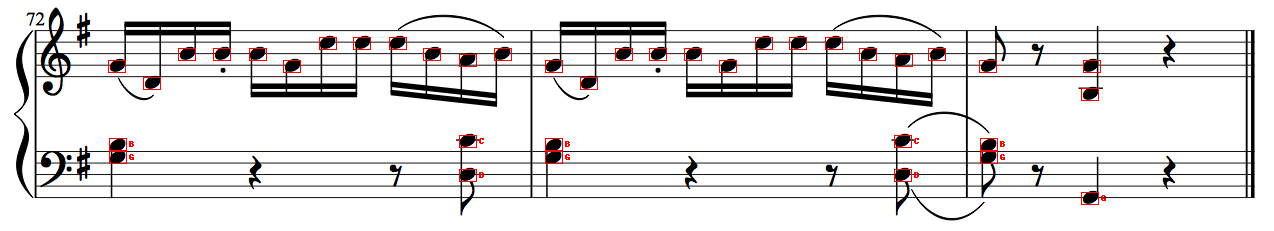

In [749]:
img_rgb

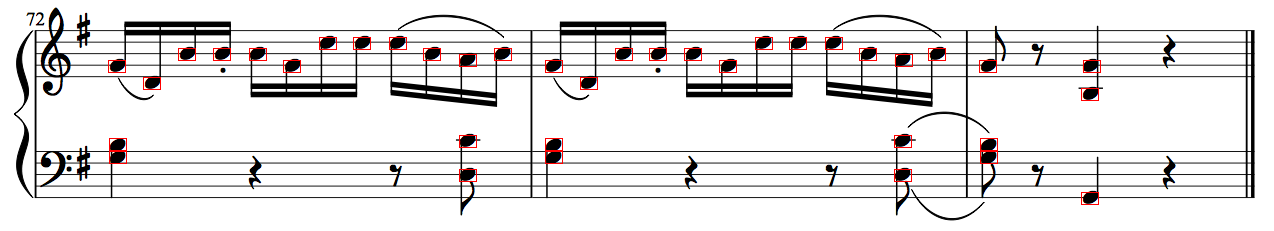

In [673]:
img_rgb

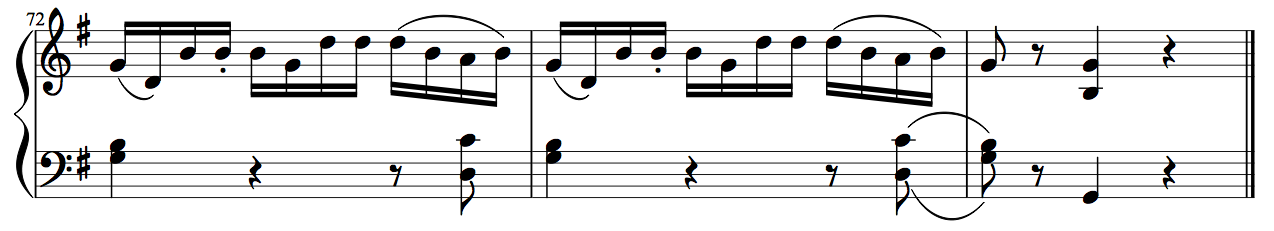

In [674]:
image